# 0.0 IMPORTS

## 0.1 Libraries

In [13]:
#!pip install inflection

  Using cached inflection-0.5.1-py2.py3-none-any.whl (9.5 kB)


In [49]:
import random
import bisect
import warnings
import inflection

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
from matplotlib          import pyplot as plt
#from matplotlib.gridspec import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from sklearn.preprocessing   import OneHotEncoder

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
#======================================== Rename DataFrame Columns ========================================#
def rename_columns(df01):
    # snakecase
    snakecase = lambda col: inflection.underscore(col)
    new_columns = list(map(snakecase, df01.columns))

    # rename
    df01.columns = new_columns
    
    return df01


#========================================== Statistical Summary ==========================================#
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m


#========================================== Cramer V (Correlation) ==========================================#
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



#========================================== Machine Learning Scores ==========================================#
def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name'            : model_name, 
                       'Precision'                : precision, 
                       'Recall'                   : recall,
                       'F1 Score'                 : f1,
                       'Kappa'                    : kappa,
                       'Balanced Accuracy'        : balanced_accuracy,
                       'Average Precision Score'  : ap,
                       'ROC AUC'                  : roc_auc}, index=[0])


#====================================== Machine Learning Cross Validation ======================================#
def cross_validation(X_train, y_train, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    model_name = type(model).__name__

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [7]:
df_raw = pd.read_csv('../01-Data/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DATA DESCRIPTION

In [8]:
df01 = df_raw.copy()

## 1.1 Data Information
---

> - **RowNumber:**       Corresponds to the record (row) number;
> - **CustomerId:**      Contains unique identifier;
> - **Surname:**         Customer's surname;
> - **CreditScore:**     Customer's credit score for the consumer market;
> - **Geography:**       Customer’s country;
> - **Gender:**          Customer's gender;
> - **Age:**             Customer's age;
> - **Tenure:**          Number of years that the customer has been a client of the bank;
> - **Balance:**         The amount that the customer has in the bank account;
> - **NumOfProducts:**   Refers to the number of products that a customer has purchased through the bank;
> - **HasCrCard:**       Denotes whether or not a customer has a credit card;
> - **IsActiveMember:**  Denotes whether or not a customer is an active member;
> - **EstimatedSalary:** Estimate customer's annually income;
> - **Exited:**          Whether or not the customer is in Churn;

## 1.2 Columns

In [9]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### 1.2.1 Rename Columns

In [15]:
df01 = rename_columns(df01)

### 1.2.2 New Columns Name

In [16]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Dimensions

In [17]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


## 1.4 Data Types

In [18]:
df01.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5 NA Check

In [19]:
df01.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.6 Check Balanced Data

In [20]:
df01['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [21]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [24]:
statistical_summary(num_attributes.drop(['row_number', 'customer_id'], axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,credit_score,350.00,850.00,500.00,850.00,650.528800,652.000,489.0000,521.00,584.00,718.0000,778.000,812.0000,96.648466,0.148569,-0.071607,-0.425726
1,age,18.00,92.00,74.00,37.00,38.921800,37.000,25.0000,27.00,32.00,44.0000,53.000,60.0000,10.487282,0.269445,1.011320,1.395347
2,tenure,0.00,10.00,10.00,2.00,5.012800,5.000,1.0000,1.00,3.00,7.0000,9.000,9.0000,2.892030,0.576929,0.010991,-1.165225
3,balance,0.00,250898.09,250898.09,0.00,76485.889288,97198.540,0.0000,0.00,0.00,127644.2400,149244.792,162711.6690,62394.285254,0.815762,-0.141109,-1.489412
4,num_of_products,1.00,4.00,3.00,1.00,1.530200,1.000,1.0000,1.00,1.00,2.0000,2.000,2.0000,0.581625,0.380098,0.745568,0.582981
5,has_cr_card,0.00,1.00,1.00,1.00,0.705500,1.000,0.0000,0.00,0.00,1.0000,1.000,1.0000,0.455818,0.646092,-0.901812,-1.186973
6,is_active_member,0.00,1.00,1.00,1.00,0.515100,1.000,0.0000,0.00,0.00,1.0000,1.000,1.0000,0.499772,0.970243,-0.060437,-1.996747
7,estimated_salary,11.58,199992.48,199980.90,24924.92,100090.239881,100193.915,9851.8185,20273.58,51002.11,149388.2475,179674.704,190155.3755,57507.617221,0.574558,0.002085,-1.181518
8,exited,0.00,1.00,1.00,0.00,0.203700,0.000,0.0000,0.00,0.00,0.0000,1.000,1.0000,0.402748,1.977165,1.471611,0.165671


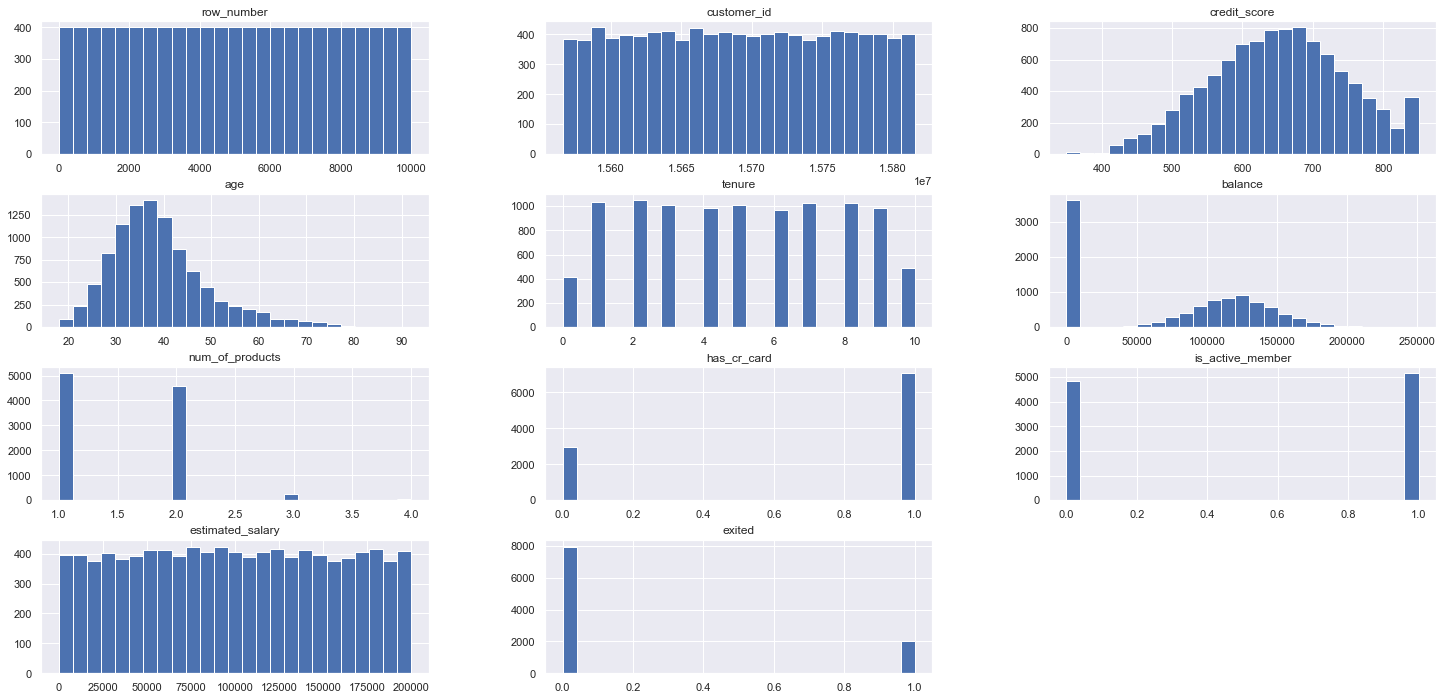

In [27]:
num_attributes.hist(bins=25);

### 1.6.2 Categorical Attributes

In [28]:
cat_attributes.describe()

,surname,geography,gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


## 1.7 First Conclusions

#### 1.5.1.2 Some considerations
---
> **age**
>> - The age range is large and it will be interesting to group by bands
>> - 50% are between 32 and 44 years (Adults)
>
> **balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - Almost 38% equals 0.00
>
> **credit_score**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **estimated_salary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a uniform distribution with great dispersion
>
> **has_cr_card**
>> - 75% has credit card
>
> **is_active_member**
>> - 50% of the customers has done a bank activity in the past 12 months
>
> **num_of_products**
>> - all customers have bought at least one product
>
> **tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>

>
> **exited**
>> - Customers in Churn: 20% (Disbalanced Dataset) 

# 2.0 Feature Engineering

In [29]:
df02 = df01.copy()

In [34]:
# Tenure Vigency
df02['tenure_vigency'] = df02['tenure'] + 1

# tenure_vigency / age
df02['tenure_vigency_age'] = df02['tenure_vigency'] / df02['age']

# credit_score / tenure_vigency
df02['cred_score_tenure_vigency'] = df02['credit_score'] / df02['tenure_vigency']

# credit_score / age
df02['cred_age'] = df02['credit_score'] / df02['age']

# amount
df02['amount'] = df02['estimated_salary'] + df02['balance']

# amount / credit_score
df02['amount_credit'] = df02['amount'] / df02['credit_score']

# amount / tenure_vigency
df02['amount_tenure_vigency'] = df02['amount'] / df02['tenure_vigency']

# amount / num_of_products
df02['amount_num_of_products'] = df02['amount'] / df02['num_of_products']

# credit score / num_of_products
df02['cred_num_of_products'] = df02['credit_score'] / df02['num_of_products']

# balance / tenure_vigency
df02['bal_tenure_vigency'] = df02['balance'] / df02['tenure_vigency']

# num_of_products - credit card
df02['num_of_products_has_cr_card_sub'] = df02['num_of_products'] - df02['has_cr_card']

# num_of_products * credit card
df02['num_of_products_has_cr_card_mul'] = df02['num_of_products'] * df02['has_cr_card']

# tenure_vigency_age * balance
df02['tenure_vigency_age_balance'] = df02['tenure_vigency_age'] * df02['balance']

# balance * is_active_member
df02['balance_is_active_member'] = df02['balance'] * df02['is_active_member']

# Group Age
df02['age_group'] = df02['age'].apply(lambda row: age_stage(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)




#################### colocar Médias, medianas, STD, MAX, MIN

# 3.0 Balanced Dataset

In [50]:
df03 = df02.copy()

## 3.4 SMOTE + TOMEKLINK

In [51]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df03.select_dtypes(include=['int64', 'float64']).drop('exited', axis=1).columns.tolist()

# Categorical
col_cat = df03.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df03_dummy = pd.DataFrame(ohe.fit_transform(df03[col_cat]).toarray(), index=df03.index)

# join Numerical and Categorical
df03_1 = pd.concat([df03[col_num], df03_dummy], axis=1)

In [60]:
ratio_balanced = {
                    0: 7963,
                    1: 3*2037
                }

#ratio_balanced

In [61]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df03_1, df03['exited'])

In [62]:
# numerical data
df03_2 = X_smt[col_num]

# categorical data
df03_3 = X_smt.drop(col_num, axis=1)
df03_4 = pd.DataFrame(ohe.inverse_transform(df03_3), columns=col_cat, index=df03_3.index)

# join numerical and categorical
df03_5 = pd.concat([df03_2, df03_4], axis=1)
df03_5['exited'] = y_smt

# 4.0 Exploratory Data Analysis (EDA)

In [66]:
df04_u = df03.copy()
df04 = df03_5.copy()

## 4.1 Mind Map

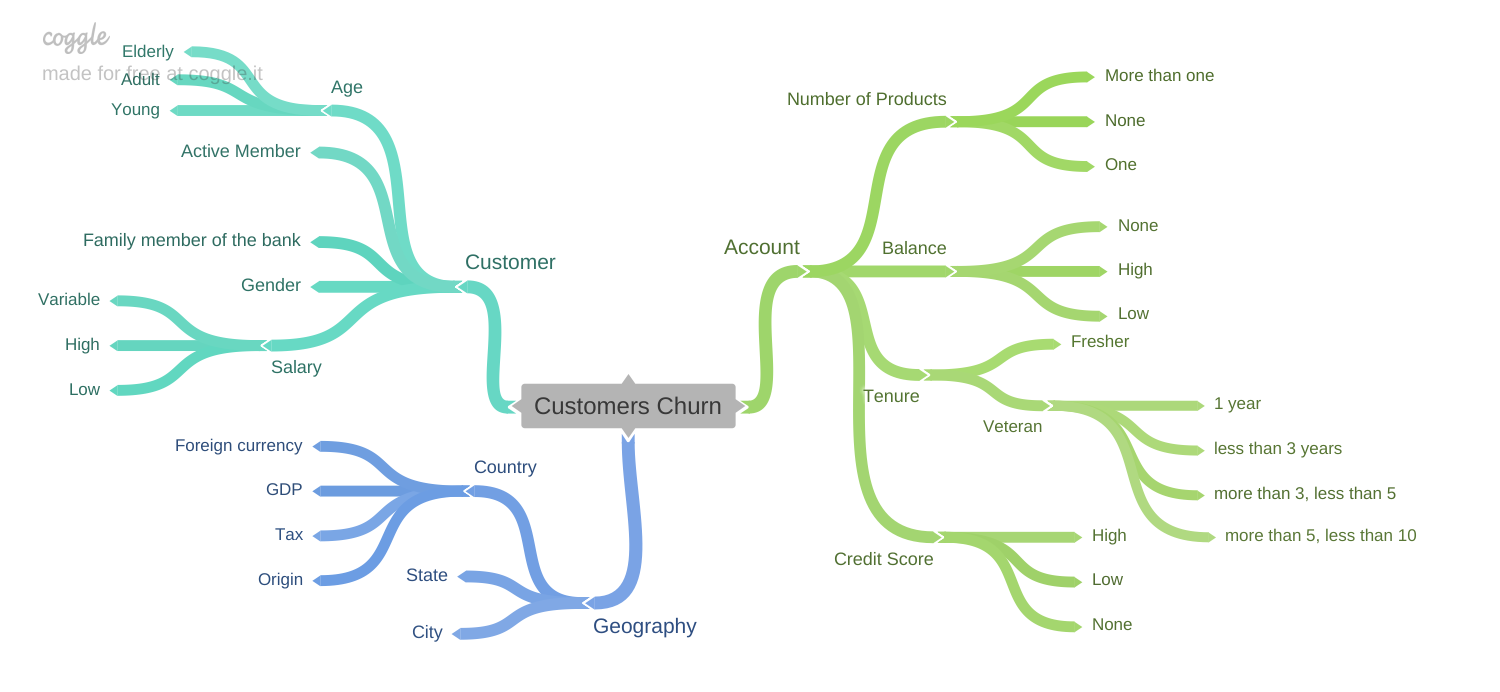

In [32]:
Image('../img/01-FirstCycleCRISPCostumerChurn.png')

## 4.2 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Customers with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Churn should occur for customers with high salary
>> - H07 - Churn should occur for customers with high balance
>
> **Geography**
>> - H01 - Countries with higher GDP should have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin should have higher number of churn
>
> **Account**
>> - H01 - Active members should have less churn
>> - H02 - Active members should have more products
>> - H03 - The more products the customer has, the less likely it is to go into churn
>> - H04 - Customers with credit cards are more active
>> - H05 - Churn should occur for customers with low tenur
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

## 4.2 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Younger clients are less loyal and more likely to leave a bank
> - H03 - Churn should occur for customers with high salary
> - H04 - Churn should occur for customers with high balance
> - H05 - Countries of Latin origin should have higher number of churn
> - H06 - Active members should have less churn
> - H07 - Churn should occur for customers with low tenure
> - H08 - The more products the customer has, the less likely it is to go into churn
> - H09 - Customers with Credit Cards tend to stay at the bank

## 4.3 Response Variable

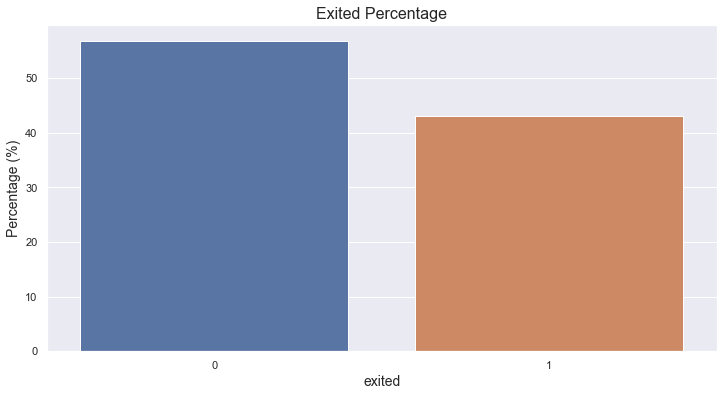

In [67]:
exited_percentage = df04['exited'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=exited_percentage.index, y=exited_percentage);
plt.ylabel('Percentage (%)', fontsize=14);
plt.xlabel('exited', fontsize=14);
plt.title('Exited Percentage', fontsize=16);

## 4.4 Univariate Analysis

### 4.4.1 Numerical Attributes

In [69]:
num_attributes = df04.select_dtypes(include=['int64', 'float64'])
statistical_summary(num_attributes)

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,row_number,1.000000e+00,1.000000e+04,9999.000000,3.229000e+03,4.985405e+03,4.980500e+03,6.344500e+02,1.187900e+03,2.687250e+03,7.275750e+03,8.784100e+03,9.357550e+03,2742.631991,0.550132,0.004876,-1.109574
1,customer_id,1.556570e+07,1.581566e+07,249959.000000,1.567998e+07,1.569035e+07,1.568978e+07,1.557979e+07,1.559137e+07,1.562789e+07,1.575321e+07,1.578972e+07,1.580205e+07,71792.729053,0.004576,0.013730,-1.211044
2,credit_score,3.500000e+02,8.500000e+02,500.000000,8.500000e+02,6.488437e+02,6.500000e+02,4.950000e+02,5.270000e+02,5.850000e+02,7.130000e+02,7.710000e+02,8.030000e+02,92.725142,0.142908,-0.065937,-0.341457
3,age,1.800000e+01,9.200000e+01,74.000000,3.800000e+01,4.052873e+01,3.900000e+01,2.600000e+01,2.900000e+01,3.300000e+01,4.600000e+01,5.400000e+01,5.900000e+01,10.179533,0.251168,0.665786,0.694418
4,tenure,0.000000e+00,1.000000e+01,10.000000,5.000000e+00,4.923979e+00,5.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00,9.000000e+00,9.000000e+00,2.817621,0.572224,0.017029,-1.121186
5,balance,0.000000e+00,2.508981e+05,250898.090000,0.000000e+00,8.058712e+04,1.026860e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.284189e+05,1.486602e+05,1.622457e+05,61261.899044,0.760195,-0.276580,-1.400720
6,num_of_products,1.000000e+00,4.000000e+00,3.000000,1.000000e+00,1.495768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,0.612252,0.409323,0.983752,0.683115
7,has_cr_card,0.000000e+00,1.000000e+00,1.000000,1.000000e+00,6.399406e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.480017,0.750097,-0.583130,-1.660206
8,is_active_member,0.000000e+00,1.000000e+00,1.000000,0.000000e+00,4.548627e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.497958,1.094745,0.181310,-1.967419
9,estimated_salary,1.158000e+01,1.999925e+05,199980.900000,2.492492e+04,1.009130e+05,1.013009e+05,1.067703e+04,2.068122e+04,5.192877e+04,1.503365e+05,1.800034e+05,1.896107e+05,57382.184731,0.568630,-0.016040,-1.193251


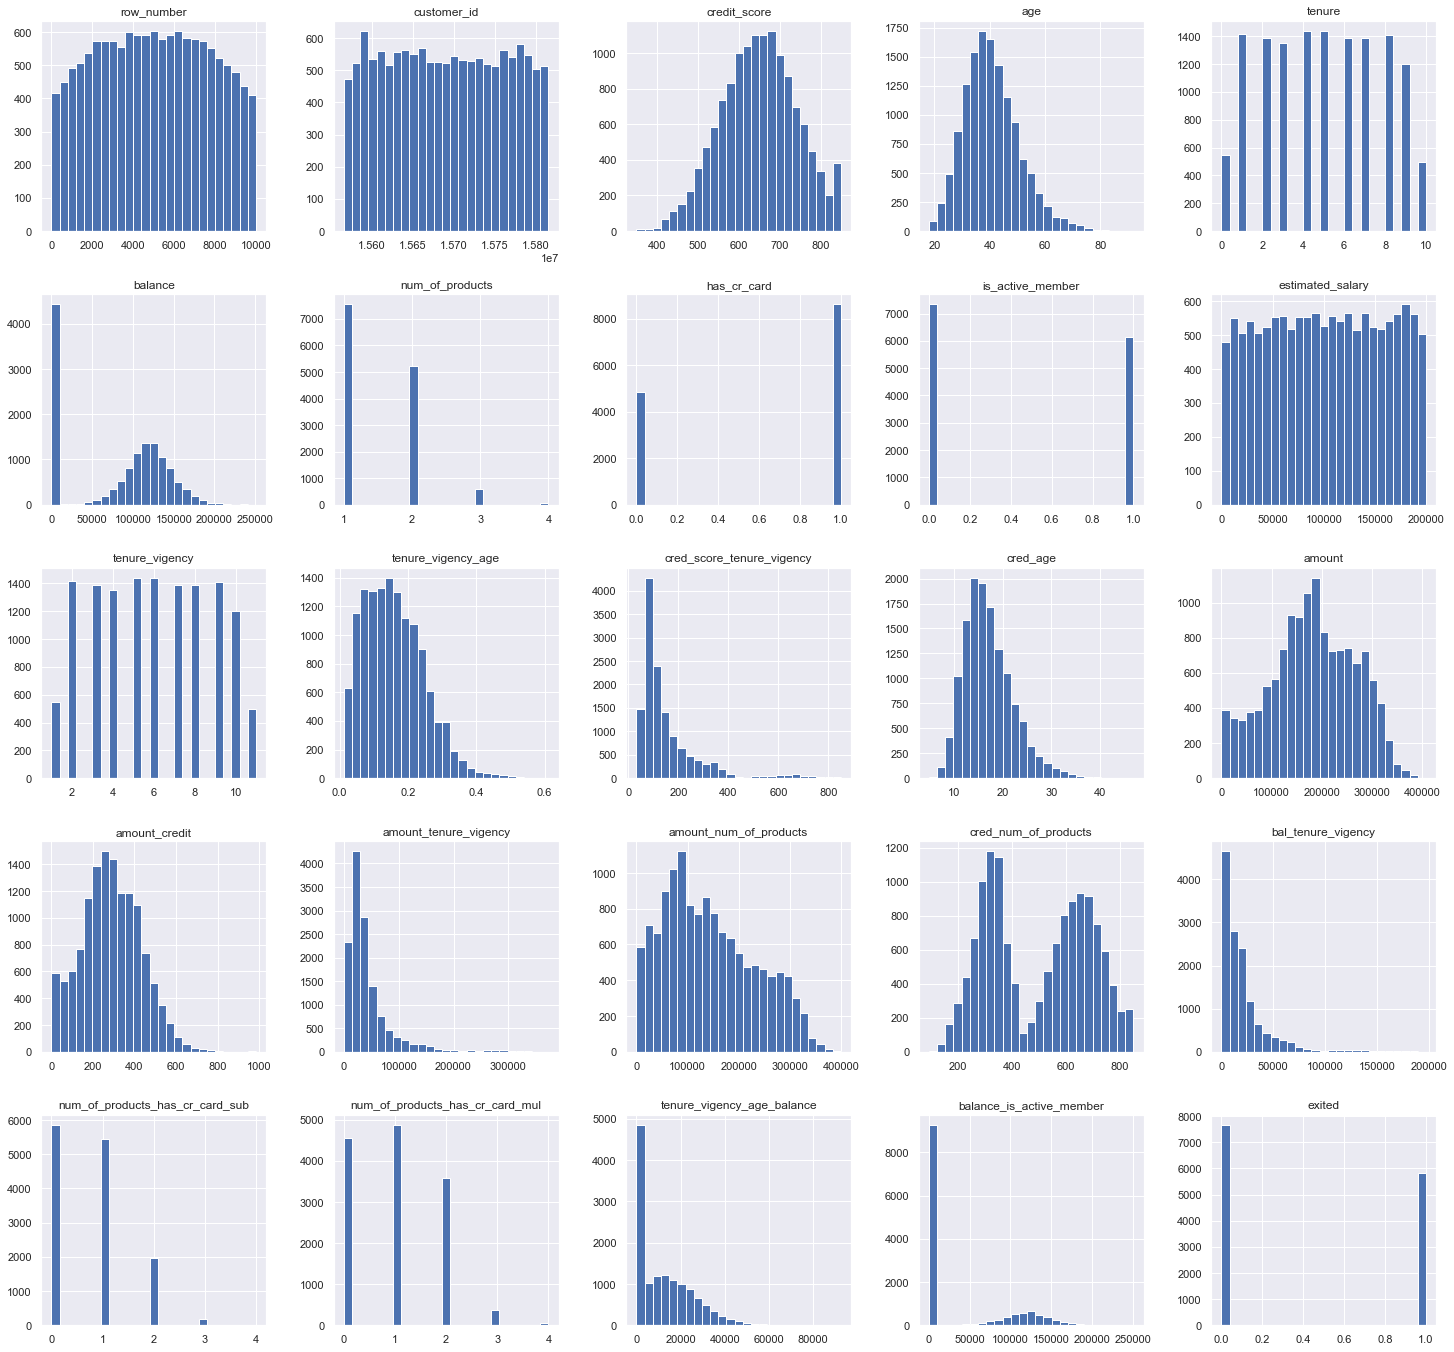

In [70]:
num_attributes.hist(bins=25, figsize=(25,24));

### 4.4.2 Categorical Attributes

In [ ]:
cat_attributes = df04.select_dtypes(include=['object'])

count = 1
rows= len(cat_attributes.columns)
plt.figure(figsize=(25,5*rows))
for i in cat_attributes:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df04)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df04)
    count += 1
plt.show()

## 4.5 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)